<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/Update9_BTC_Price_Forecasting_with_yfinance_and_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bitcoin Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from fbprophet import Prophet
import plotly.io as pio
pio.renderers.default='colab'

     |████████████████████████████████| 6.4 MB 7.7 MB/s 
     |████████████████████████████████| 63 kB 425 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Importing the Dataset & Exploring it

In [32]:
 # Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '3y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: BTC-USD
You entered BTC-USD, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
1087,2022-01-31,37920.281250,38647.261719,36733.574219,38483.125000,20734730465,0,0
1088,2022-02-01,38481.765625,39115.132812,38113.664062,38743.273438,20288500328,0,0
1089,2022-02-02,38743.714844,38834.617188,36832.730469,36952.984375,19155189416,0,0
1090,2022-02-03,36944.804688,37154.601562,36375.539062,37154.601562,18591534769,0,0
1091,2022-02-04,37149.265625,41527.785156,37093.628906,41500.875000,29412210792,0,0
1092,2022-02-05,41501.480469,41847.164062,41038.097656,41441.164062,19652846215,0,0
1093,2022-02-06,41441.121094,42500.785156,41244.906250,42412.433594,16142097334,0,0
1094,2022-02-07,42406.781250,44401.863281,41748.156250,43840.285156,28641855926,0,0
1095,2022-02-08,43854.652344,45293.867188,42807.835938,44118.445312,33079398868,0,0
1096,2022-02-09,44053.984375,44577.816406,43249.785156,44500.812500,24367575040,0,0


In [33]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1097.000000,1097.000000,1097.000000,1097.000000,1.097000e+03,1097.0,1097.0
mean,23289.406717,23906.749772,22611.270490,23322.629605,3.311454e+10,0.0,0.0
std,19146.481295,19664.563299,18533.891014,19141.656860,2.002686e+10,0.0,0.0
min,3615.270264,3646.256592,3607.697754,3616.880859,5.934744e+09,0.0,0.0
25%,8671.212891,8809.303711,8484.843750,8672.455078,1.972507e+10,0.0,0.0
50%,11017.463867,11386.261719,10830.327148,11053.614258,2.977237e+10,0.0,0.0
75%,40788.640625,42231.449219,39540.941406,40869.554688,4.108376e+10,0.0,0.0
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [34]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [35]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [36]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [37]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [38]:
def get_hurst_exponent(time_series, max_lag=100):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [39]:
hurst = pd.DataFrame(columns =["hurst_exp","lag"])
lags = range(4, 121, 1)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst = hurst.append({"hurst_exp":hurst_exp,"lag":lag},ignore_index=True)
px.line(hurst, x="hurst_exp", y="lag", title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet

In [40]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df= prophet_df.rename(columns={'Date':'ds','Close':'y'})  
prophet_df.tail()

,ds,y
1092,2022-02-05,41441.164062
1093,2022-02-06,42412.433594
1094,2022-02-07,43840.285156
1095,2022-02-08,44118.445312
1096,2022-02-09,44500.812500


## Creating Facebook Prophet Model

In [41]:
m=Prophet(daily_seasonality=False)
m.fit(prophet_df)

##Forecasting

In [42]:
periods = 30
future=m.make_future_dataframe(periods)

In [43]:
forecast=m.predict(future)

In [44]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-02-09,1471.577119,-4638.071812,5587.886878,1471.577119,1471.577119,-997.622055,-997.622055,-997.622055,35.517434,35.517434,35.517434,-1033.139490,-1033.139490,-1033.139490,0.0,0.0,0.0,473.955063
1,2019-02-10,1541.113974,-4100.226482,6634.216358,1541.113974,1541.113974,-485.828571,-485.828571,-485.828571,25.782728,25.782728,25.782728,-511.611299,-511.611299,-511.611299,0.0,0.0,0.0,1055.285403
2,2019-02-11,1610.650829,-3308.393550,6834.707785,1610.650829,1610.650829,23.637428,23.637428,23.637428,29.446084,29.446084,29.446084,-5.808656,-5.808656,-5.808656,0.0,0.0,0.0,1634.288257
3,2019-02-12,1680.187685,-3389.889759,7000.455852,1680.187685,1680.187685,416.814703,416.814703,416.814703,-60.049033,-60.049033,-60.049033,476.863737,476.863737,476.863737,0.0,0.0,0.0,2097.002388
4,2019-02-13,1749.724540,-2411.271556,7849.860646,1749.724540,1749.724540,944.632278,944.632278,944.632278,15.065032,15.065032,15.065032,929.567247,929.567247,929.567247,0.0,0.0,0.0,2694.356818
5,2019-02-14,1819.261395,-1901.954694,7522.321474,1819.261395,1819.261395,1293.656709,1293.656709,1293.656709,-52.502168,-52.502168,-52.502168,1346.158877,1346.158877,1346.158877,0.0,0.0,0.0,3112.918104
6,2019-02-15,1888.798250,-1815.076739,8891.011530,1888.798250,1888.798250,1728.043989,1728.043989,1728.043989,6.739924,6.739924,6.739924,1721.304066,1721.304066,1721.304066,0.0,0.0,0.0,3616.842240
7,2019-02-16,1958.335106,-1499.829018,9229.664638,1958.335106,1958.335106,2086.087842,2086.087842,2086.087842,35.517434,35.517434,35.517434,2050.570408,2050.570408,2050.570408,0.0,0.0,0.0,4044.422948
8,2019-02-17,2027.871961,-768.092710,9423.959865,2027.871961,2027.871961,2356.283153,2356.283153,2356.283153,25.782728,25.782728,25.782728,2330.500425,2330.500425,2330.500425,0.0,0.0,0.0,4384.155114
9,2019-02-18,2097.408816,-339.643804,9833.888393,2097.408816,2097.408816,2588.108127,2588.108127,2588.108127,29.446084,29.446084,29.446084,2558.662044,2558.662044,2558.662044,0.0,0.0,0.0,4685.516944


In [45]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

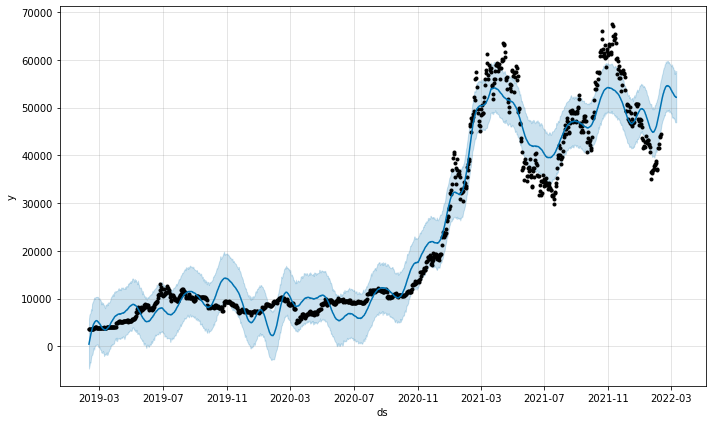

In [46]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

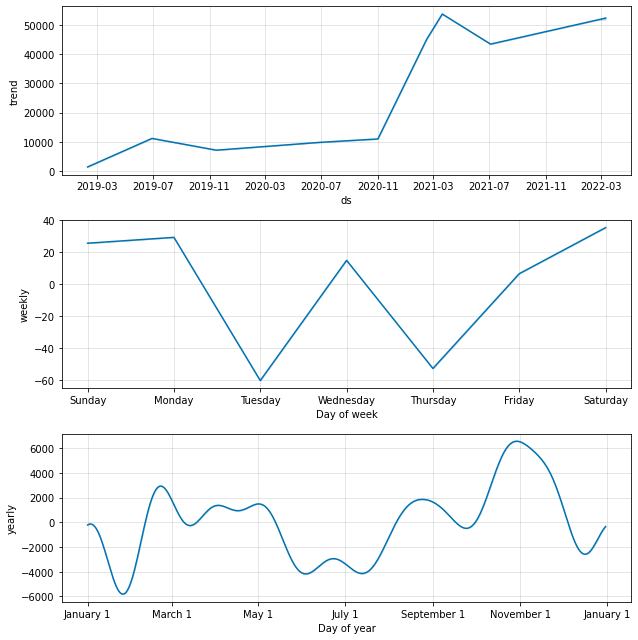

In [47]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [18]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>